# %%[markdown]

 # Test Calibrate Interface

 Run Calibrate and do exploratory analysis of the results.

In [ ]:
# %%

import os
import pyciemss
import torch
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.observation import load_data

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

In [ ]:
# %%

# Models and datasets
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
d = load_data(dataset1)
d = {"timepoint": d[0]} | d[1]
d = {k: v.numpy() for k, v in d.items()}
dataset1_df = pd.DataFrame(d)

Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


In [ ]:
# %%

# Calibrate Settings

start_time = 0.0
end_time = 5.0
logging_step_size = 0.1
num_samples = 100

In [ ]:
# %%

# Run pre-calibration Simulate

result_precalibrate = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)

result_precalibrate["data"].head()

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,S_state,I_state,E_state,R_state,H_state,D_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,0.0,0.265914,0.520951,0.499348,0.166911,0.013599,3.346875,19339996.0,3.346875,40.000000,0.000000,0.000000,0.000000,3.346875,40.000000,0.000000,0.000000
1,1,0,0.1,0.265914,0.520951,0.499348,0.166911,0.013599,3.346875,19339996.0,4.149405,39.205582,0.156426,0.030982,0.000004,4.149405,39.205582,0.030982,0.000004
2,2,0,0.2,0.265914,0.520951,0.499348,0.166911,0.013599,3.346875,19339996.0,4.894210,38.470516,0.345691,0.067730,0.000017,4.894210,38.470516,0.067730,0.000017
3,3,0,0.3,0.265914,0.520951,0.499348,0.166911,0.013599,3.346875,19339996.0,5.585498,37.790585,0.565590,0.109672,0.000041,5.585498,37.790585,0.109672,0.000041
4,4,0,0.4,0.265914,0.520951,0.499348,0.166911,0.013599,3.346875,19339996.0,6.227170,37.161690,0.814076,0.156281,0.000077,6.227170,37.161690,0.156281,0.000077


In [ ]:
# %%

# Run Calibrate

data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10

result_calibrate = pyciemss.calibrate(
    model1, 
    dataset1, 
    data_mapping = data_mapping, 
    num_iterations = num_iterations
)

Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


In [ ]:
# %%

result_calibrate

# result_calibrate = {
#     "inferred_parameters": AutoGuideList((0): AutoDelta(), (1): AutoLowRankMultivariateNormal())
#     "loss": <float>y
# }

{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 43.67785727977753}

In [ ]:
# %%

parameter_estimates = result_calibrate["inferred_parameters"]
parameter_estimates()

# parameter_estimates() = {
#     'persistent_beta_c': tensor(0.4848, grad_fn=<ExpandBackward0>),
#     'persistent_kappa': tensor(0.4330, grad_fn=<ExpandBackward0>),
#     'persistent_gamma': tensor(0.3387, grad_fn=<ExpandBackward0>),
#     'persistent_hosp': tensor(0.0777, grad_fn=<ExpandBackward0>),
#     'persistent_death_hosp': tensor(0.0567, grad_fn=<ExpandBackward0>),
#     'persistent_I0': tensor(9.1598, grad_fn=<ExpandBackward0>)
# }

{'persistent_beta_c': tensor(0.3421, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.6139, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.3141, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1292, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0543, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(9.0083, grad_fn=<ExpandBackward0>)}

In [ ]:
# %%

# Run post-calibration Simulate
result_postcalibrate = pyciemss.sample(
    model1, 
    end_time, 
    logging_step_size, 
    num_samples,
    start_time = start_time, 
    inferred_parameters = result_calibrate["inferred_parameters"]
)

result_postcalibrate["data"].head()

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,S_state,I_state,E_state,R_state,H_state,D_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,0.0,0.334471,0.559514,0.291883,0.125482,0.056619,8.918121,19339992.0,8.918121,40.000000,0.000000,0.000000,0.000000,8.918121,40.000000,0.000000,0.000000
1,1,0,0.1,0.334471,0.559514,0.291883,0.125482,0.056619,8.918121,19339992.0,9.641140,39.525356,0.237254,0.033664,0.000019,9.641140,39.525356,0.033664,0.000019
2,2,0,0.2,0.334471,0.559514,0.291883,0.125482,0.056619,8.918121,19339992.0,10.332301,39.101540,0.493205,0.069225,0.000077,10.332301,39.101540,0.069225,0.000077
3,3,0,0.3,0.334471,0.559514,0.291883,0.125482,0.056619,8.918121,19339992.0,10.993748,38.725597,0.767102,0.106533,0.000176,10.993748,38.725597,0.106533,0.000176
4,4,0,0.4,0.334471,0.559514,0.291883,0.125482,0.056619,8.918121,19339990.0,11.627454,38.394642,1.058245,0.145450,0.000319,11.627454,38.394642,0.145450,0.000319


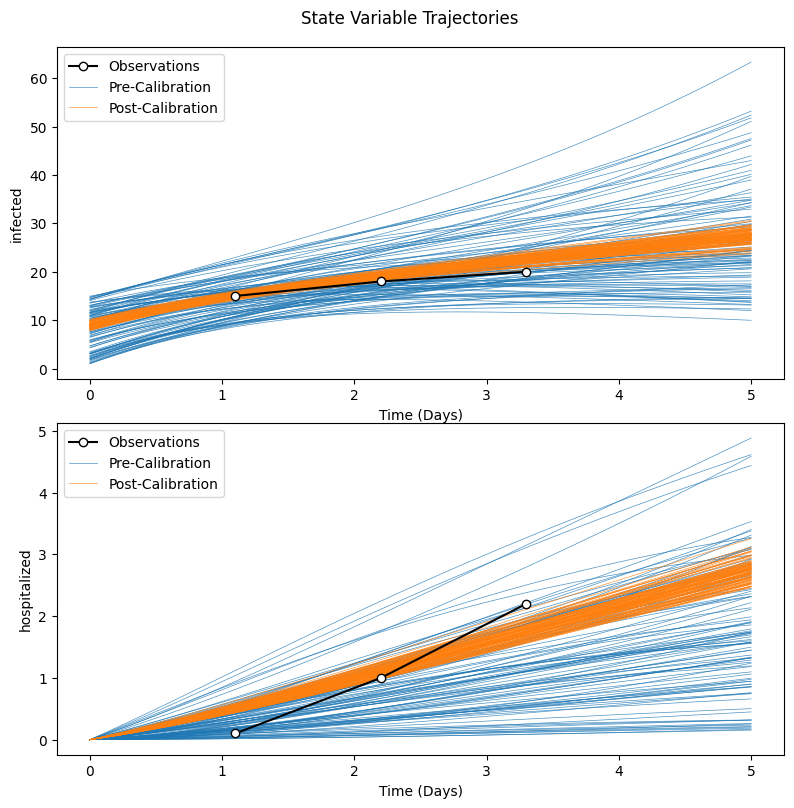

In [ ]:
# %%

# Plot trajectories

cmap = mpl.colormaps["tab10"](range(10))
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 8))
fig.suptitle("State Variable Trajectories")
fig.tight_layout()

for ax, (train_data_state, model_state) in zip(axes, data_mapping.items()):

    # Pre-/post-calibrate trajectories
    for result_, label, color in zip((result_precalibrate, result_postcalibrate), ("Pre-Calibration", "Post-Calibration"), (cmap[0, :], cmap[1, :])):

        # Timepoints
        x = result_["data"][result_["data"]["sample_id"] == 0]["timepoint_unknown"]

        for i in range(num_samples):
            result = result_["data"][result_["data"]["sample_id"] == i]
            
            if "_".join([model_state, "state"]) in result.columns:
                l = "_".join([model_state, "state"])
                y = result[l]
            elif "_".join([model_state, "observable", "state"]) in result.columns:
                l = "_".join([model_state, "observable", "state"])
                y = result[l]
            else:
                l = None
                y = None
            
            if ~isinstance(y, type(None)):
                ax.plot(x, y, linewidth = 0.5, color = color, alpha = 0.8, label = label)


    # Training dataset trajectories
    ax.plot(dataset1_df["timepoint"], dataset1_df[train_data_state], marker = "o", color = "black", markeredgecolor = "black", markerfacecolor= "white", label = train_data_state)      
    
    # Axis labels
    __ = plt.setp(ax, xlabel = "Time (Days)", ylabel = model_state)

    # Legend
    l = [
        mpl.lines.Line2D([0], [0], label = "Observations", marker = "o", color = "black", markeredgecolor = "black", markerfacecolor= "white"),
        mpl.lines.Line2D([0], [0], label = "Pre-Calibration", linewidth = 0.5, color = cmap[0, :], alpha = 0.8),
        mpl.lines.Line2D([0], [0], label = "Post-Calibration", linewidth = 0.5, color = cmap[1, :], alpha = 0.8)
    ]
    __ = ax.legend(handles = l)


fig.savefig("./figures/test_calibrate_interface_state_trajectories.png")

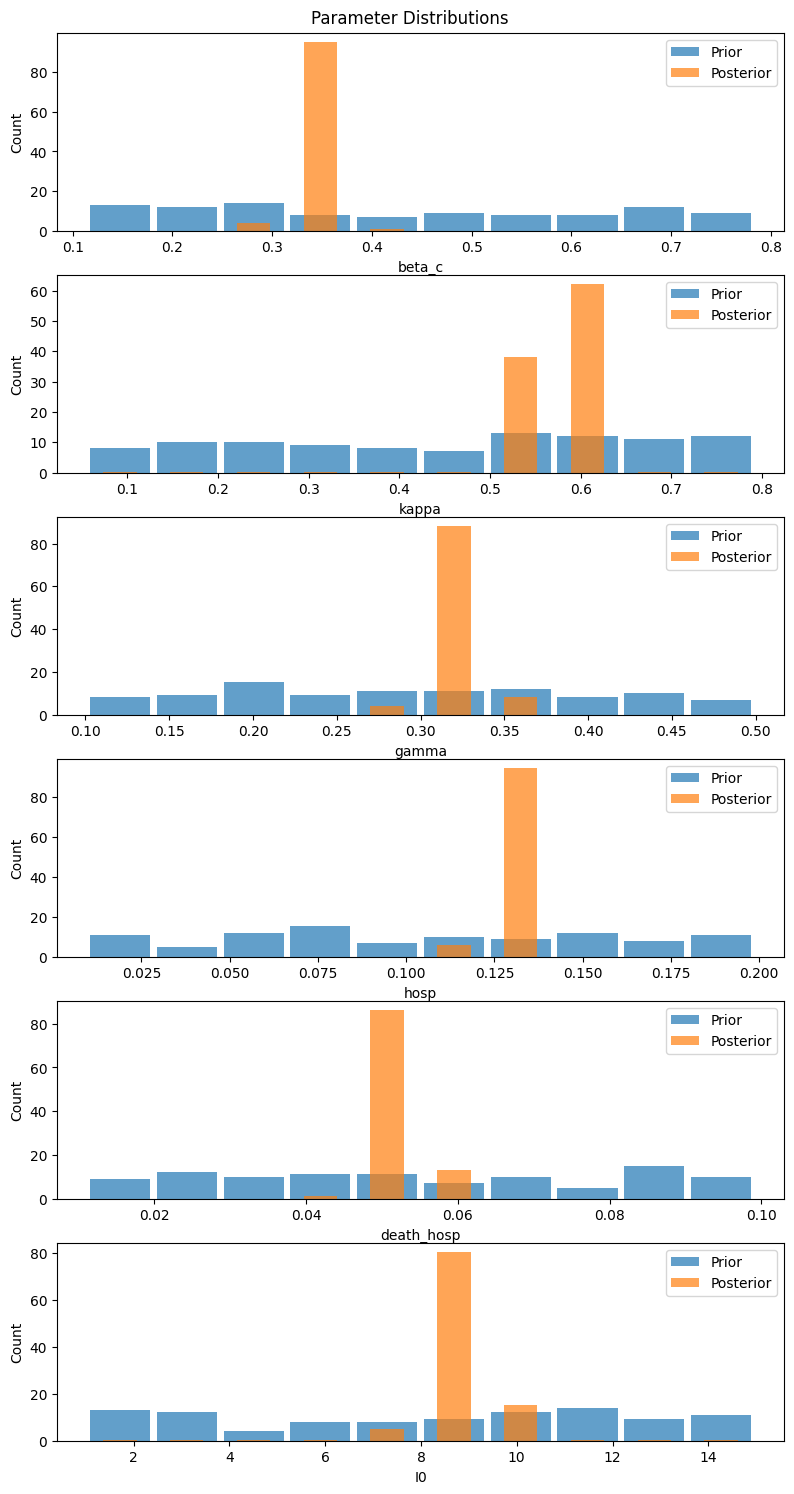

In [ ]:
# %%

# Plot parameter distributions

parameters = list(parameter_estimates().keys())
num_parameters = len(parameters)

fig, axes = plt.subplots(nrows = num_parameters, ncols = 1, figsize = (8, 15))
fig.suptitle("Parameter Distributions")
fig.tight_layout()

for ax, p in zip(axes, parameters):
    

    # Pre-/post-calibrate trajectories
    for i, (result_, label, color) in enumerate(zip((result_precalibrate, result_postcalibrate), ("Prior", "Posterior"), (cmap[0, :], cmap[1, :]))):

        # Filter the result dataset
        result = result_["data"][result_["data"]["timepoint_id"] == 0]
        samples = result[p + "_param"]
        
        # Compute histogram (use the pre-calibrate bins for the post-calibrate dataset)
        if i == 0:
            h, b = np.histogram(samples, density = False)
            w = b[1] - b[0]
        else:
            h, b = np.histogram(samples, density = False, bins = b)


        # x coor to center the bars
        x = 0.5 * (b[1:] + b[0:-1])

        if i == 0:
            __ = ax.bar(x, h + 0.1, width = 0.9 * w, align = "center", label = label, alpha = 0.7)
        else:
            __ = ax.bar(x, h + 0.1, width = 0.5 * w, align = "center", label = label, alpha = 0.7)


    # Legend
    l = [
        mpl.patches.Patch(facecolor = cmap[0, :], alpha = 0.7, label = "Prior"),
        mpl.patches.Patch(facecolor = cmap[1, :], alpha = 0.7, label = "Posterior"),
    ]
    __ = ax.legend(handles = l)

    # Axis labels
    xlabel = "_".join(p.split("_")[1:])
    __ = plt.setp(ax, xlabel = xlabel, ylabel = "Count")


fig.savefig("./figures/test_calibrate_interface_parameter_distributions.png")

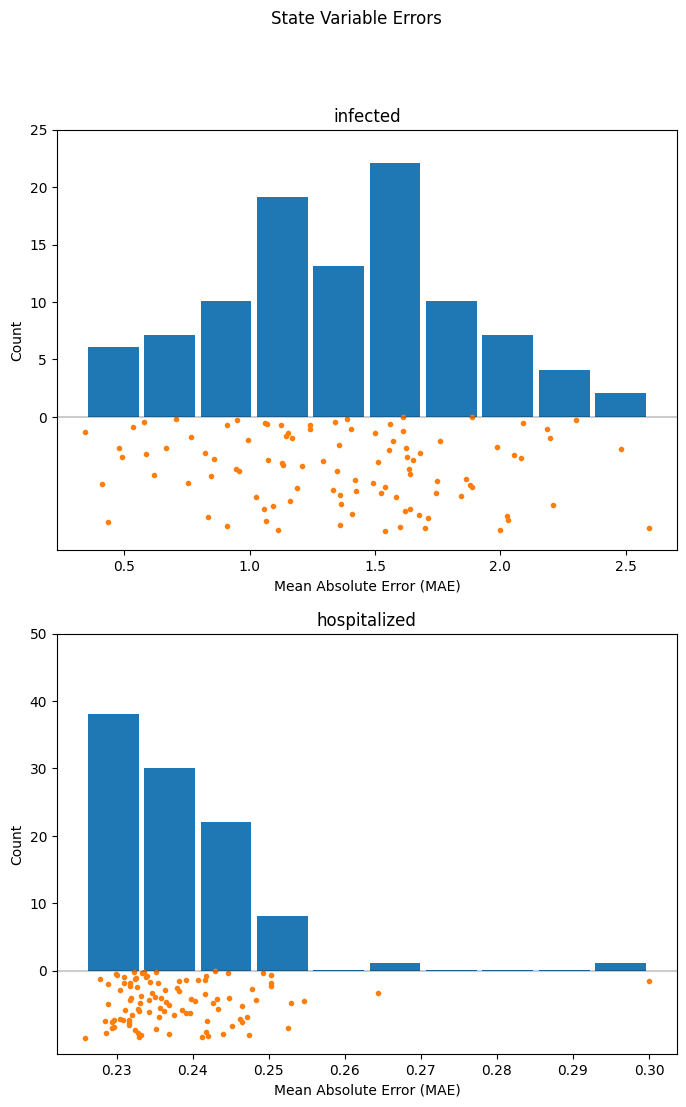

In [ ]:
# %%

# Plot errors

# RNG seed
rng = np.random.default_rng(0)


cmap = mpl.colormaps["tab10"](range(10))
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 12))
fig.suptitle("State Variable Errors")
# fig.tight_layout()

for ax, (train_data_state, model_state) in zip(axes, data_mapping.items()):

    # Interpolate training dataset over same timepoints as Calibrate results
    x_train = dataset1_df["timepoint"]
    y_train = dataset1_df[train_data_state]
    x_postcalibrate = result_postcalibrate["data"][result_postcalibrate["data"]["sample_id"] == 0]["timepoint_unknown"]
    x_postcalibrate = x_postcalibrate[(x_postcalibrate >= min(x_train)) & (x_postcalibrate <= max(x_train))]
    y_train_interp = np.interp(x_postcalibrate, x_train, y_train, left = None, right = None)

    # Repeat interpolated y values to align with Calibrate results
    y_train_interp_repeat = pd.concat([pd.DataFrame(y_train_interp)] * num_samples, axis = 0)
    y_train_interp_repeat = y_train_interp_repeat.reset_index(drop = True)[0]

    # Get Calibrate result column name of the model state variable (as named in the data mapping)
    if "_".join([model_state, "state"]) in result.columns:
        l = "_".join([model_state, "state"])
    elif "_".join([model_state, "observable", "state"]) in result.columns:
        l = "_".join([model_state, "observable", "state"])
    else:
        l = None

    if ~isinstance(l, type(None)):

        # Compute error (mean absolute error)
        result = result_postcalibrate["data"][result_postcalibrate["data"]["timepoint_unknown"].isin(x_postcalibrate)]
        result = result.reset_index(drop = True)
        result[l] = np.abs(result[l] - y_train_interp_repeat)
        result = result.groupby("sample_id").mean()
        error = result[l]

    # Compute histogram and plot bar chart
    h, b = np.histogram(error, density = False)
    __ = ax.bar(0.5 * (b[1:] + b[0:-1]), h + 0.1, width = 0.9 * (b[1] - b[0]), align = "center", alpha = 1.0)

    # Plot samples as rain droplets
    jitter = np.sqrt(num_samples) * (rng.random((num_samples, )) - 1.0)
    __ = ax.scatter(error, jitter, marker = ".", color = cmap[1, :])

    # Guide line
    xlim = ax.get_xlim()
    __ = ax.plot(xlim, [0.0, 0.0], color = "black", alpha = 0.2)
    __ = plt.setp(ax, xlim = xlim)

    # Axis labels
    __ = plt.setp(ax, title = model_state, xlabel = "Mean Absolute Error (MAE)", ylabel = "Count")

    # Y ticks
    yticks = ax.get_yticks()
    yticks = yticks[yticks >= 0.0]
    __ = ax.set_yticks(yticks)

fig.savefig("./figures/test_calibrate_interface_state_errors.png")